In [1]:
from IPython.display import display, Image

_unchecked_

# CNTK 103: 带 MNIST 的 D 型卷积神经网络

我们假定您已成功完成 CNTK 103 部件 A (MNIST 数据装载器)。

在本教程中, 我们将训练一个卷积神经网络 (CNN) 的 MNIST 数据。此笔记本提供使用 Python API 的食谱。如果您正在 BrainScript 中查找此示例, 请查看[此处](https://github.com/Microsoft/CNTK/tree/release/2.4/Examples/Image/GettingStarted)

## 介绍

[卷积神经网络](https://en.wikipedia.org/wiki/Convolutional_neural_network)(CNN, 或 ConvNet) 是一种[前馈](https://en.wikipedia.org/wiki/Feedforward_neural_network)) 人工神经网络, 由具有学习权重和偏差的神经元组成, 与103C 引入的普通多层感知器 (MLP) 网络非常相似。神经利用数据的空间性质。在自然界中, 我们通过形状、大小和颜色来感知不同的物体。例如, 自然场景中的对象通常是边缘、角/顶点 (由两个边缘定义)、颜色补丁等。这些原语通常是使用不同的检测器 (例如, 边缘探测, 彩色探测器) 或探测器的组合来识别, 以方便图像解释 (对象分类, 感兴趣区域, 场景描述等)在现实世界中的视觉相关任务。这些探测器也称为过滤器。卷积是一种数学运算符, 它将图像和滤镜作为输入, 并生成过滤输出 (表示输入图像中的 egdges、角、颜色等)。 从历史上看, 这些过滤器是一组通常手工制作或用数学函数建模的权重 (例如,[高斯](https://en.wikipedia.org/wiki/Gaussian_filter)/[拉普拉斯](http://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm)/[精明](https://en.wikipedia.org/wiki/Canny_edge_detector)的过滤器)。 过滤器输出通过模拟人脑细胞的非线性活化函数来映射, 称为[神经元](https://en.wikipedia.org/wiki/Neuron)。

卷积网络提供了一种机器, 可以直接从数据中学习这些过滤器, 而不是显式的数学模型, 并且与历史上精心制作的过滤器相比, 它在实际任务中被发现是优越的。 在卷积网络中, 重点是学习过滤器的权重, 而不是学习单独的完全连接的双智能 (输入和输出) 权重。这样, 与以前的教程中的传统 MLP 网络相比, 要学习的权重数就会减少。 在卷积网络中, 根据网络的复杂程度, 您可以学习几个从几个单位数到几千个的过滤器。

许多 CNN 原语已经被证明在大脑的[视觉皮层](https://en.wikipedia.org/wiki/Visual_cortex)中有一个概念上的并行组件。视觉皮层神经元细胞组在受激时发出反应。这个区域被称为接收域 (RF)。等价地, 在卷积中, 与滤波器尺寸对应的输入区域可以被看作是接受域。受欢迎的深神经或 ConvNets (如[AlexNet](https://en.wikipedia.org/wiki/AlexNet)、 [VGG](https://arxiv.org/abs/1409.1556)、[起始](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)、 [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf)), 用于各种[计算机视觉](https://en.wikipedia.org/wiki/Computer_vision)任务中有许多这些体系结构原语 (来自生物学的启发)。

在本教程中, 我们将介绍卷积运算并熟悉神经中的不同参数。

**问题**: 与在 CNTK 103C 中一样, 我们将继续处理在 MNIST 数据中识别数字的相同问题。MNIST 数据由手写数字组成, 背景噪音小。

In [2]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

_unchecked_

**目标**: 我们的目标是训练一个分类器, 它将识别 MNIST 数据集中的数字。

**方法**:

我们在前面的教程中使用的相同的5阶段是适用的: 数据读取、数据预处理、创建模型、学习模型参数和评估 (又称测试/预测) 模型。
-数据阅读: 我们将使用 CNTK 文本读取器-数据预处理: 在 A 部分 (建议的扩展部分)。

在本教程中, 我们将试验两个具有不同体系结构组件的模型。

In [3]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

_unchecked_

## 数据读取

在本节中, 我们将读取 CNTK 103 部件 A (MNIST 数据加载器) 中生成的数据。

我们正在使用您使用 CNTK_103A_MNIST_DataLoader 笔记本下载的 MNIST 数据。该数据集有6万训练图像和1万测试图像, 每个图像都是 28 x 28 像素。因此, 功能的数量等于 784 (= 28 x 28 像素), 1 每像素。变量 `num_output_classes` 设置为 10, 对应于数据集中的位数 (0-9)。

在前面的教程中, 如下所示, 我们始终将输入图像拼合到一个向量中。 使用 convoultional 网络, 我们不会以这种方式拼合图像。

![](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

**输入维度**:

在图像的卷积网络中, 输入数据通常被形状为3D 矩阵 (通道数、图像宽度、高度), 从而保留像素之间的空间关系。在上面的图中, MNIST 图像是单个通道 (灰度) 数据, 因此输入维度被指定为 (1, 图像宽度, 图像高度) 元组。

![](https://www.cntk.ai/jup/cntk103d_rgb.png)

自然场景彩色图像通常呈现为红绿蓝 (RGB) 颜色通道。此类图像的输入维度被指定为 (3, 图像宽度, 图像高度) 元组。如果你有 RGB 输入数据作为容量扫描以卷宽度、容量高度和容量深度代表3轴, 输入数据格式将由4个值的元组指定 (3, 容量宽度, 容量高度, 容量深度)。通过这种方式, CNTK 能够对任意高维空间中的输入图像进行规范。

In [5]:
# Define the data dimensions
input_dim_model = (1, 28, 28)    # images are 28 x 28 with 1 channel of color (gray)
input_dim = 28*28                # used by readers to treat input data as a vector
num_output_classes = 10

_unchecked_

**数据格式**数据以 CNTK 的格式存储在本地计算机上。 周大福格式是一个简单的文本格式, 包含一组示例, 每个样本包含一组命名字段及其数据。 对于我们的 MNIST 数据, 每个示例包含2字段: 标签和功能, 格式如下:

    `|labels 0 0 0 1 0 0 0 0 0 0 |features 0 255 0 123 ... 
                                                  (784 integers each representing a pixel gray level)
    `

在本教程中, 我们将使用对应于名为 "特征" 的整数流的图像像素。我们定义了一个 `create_reader` 函数来读取训练和测试数据, 使用[反](https://cntk.ai/pythondocs/cntk.io.html#cntk.io.CTFDeserializer).。

标签是[1 热](https://en.wikipedia.org/wiki/One-hot)编码的 (表示3的输出类的标签成为 `0001000000` , 因为我们有10类用于10可能的数字), 其中第一个索引对应于数字 `0` , 最后一个对应于数字 `9` 。

![](https://www.cntk.ai/jup/cntk103a_onehot.png)

In [6]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [7]:
# Ensure the training and test data is available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    
    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is ..\Examples\Image\DataSets\MNIST


_unchecked_

## CNN 模型创建

CNN 是由一堆层组成的前馈网络, 这样一个层的输出就变成了下一层的输入 (类似于 MLP)。在 MLP 中, 所有可能的输入像素对都连接到输出节点上, 每对具有一个权重, 从而导致要学习的参数的组合爆炸, 也增加了拟的可能性 ([详细信息](http://cs231n.github.io/neural-networks-1/))。卷积层利用像素的空间排列, 并学习多个过滤器, 大大减少了网络中的参数量 ([详细信息](http://cs231n.github.io/convolutional-networks/))。过滤器的大小是卷积层的一个参数。

在本节中, 我们将介绍卷积操作的基本知识。我们在 RGB 图像 (3 通道) 的上下文中显示插图, 即使我们在本教程中使用的 MNIST 数据是灰度图像 (单通道)。

![](https://www.cntk.ai/jup/cntk103d_rgb.png)

### 卷积层

卷积层是一组滤镜。每个筛选器都由一个权重 (**W**) 矩阵和偏置 ($ b $) 定义。

![](https://www.cntk.ai/jup/cntk103d_filterset_v2.png)

这些滤镜通过图像在权重和相应的输入值 ($ x $) 之间执行点积进行扫描。偏置值被添加到点积的输出中, 结果的总和可以通过激活函数进行映射。下面的动画演示了此过程。

In [8]:
Image(url="https://www.cntk.ai/jup/cntk103d_conv2d_final.gif", width= 300)

_unchecked_

卷积层包含以下主要功能:

- 每个卷积节点不是完全连接到所有的输入和输出节点, 而是**本地连接**到本地化为较小输入区域的输入节点子集, 也称为接收字段 (RF)。上图显示了图像中作为 RF 区域的小 3 x 3 区域。在 RGB 的情况下, 图像将有三这样的 3 x 3 区域, 每一个3色通道。

- 卷积层没有一组权重 (如稠密层), 而是有多个集 (如图中所示的多颜色), 称为**筛选器**。每个过滤器检测输入图像中每个可能 RF 的功能。 卷积的输出是一组 `n` 子层 (显示在下面的动画中), 其中 `n` 是过滤器的数量 (参见上图)。

- 在子层内, 而不是每个节点都有自己的权重集, 所以该子图层中的所有节点都使用一组**共享权重**。这样可以减少要学习的参数数, 从而拟。这也为深入学习的几个方面打开了大门, 这使得非常实用的解决方案得以建立:-处理更大的图像 (比方说 512 x 512)

- 尝试更大的过滤器大小 (对应于一个更大的 RF) 说 11 x 11

- 学习更多的过滤器 (比方说 128)

- 探索更深的体系结构 (100 层以上)

- 实现平移不变性 (能够识别独立于图像中显示位置的特征)。

_unchecked_

### 步幅和垫参数

**如何定位筛选器？**通常, 过滤器排列在重叠的图块中, 从左到右, 从上到下。 每个卷积层都有一个参数来指定 `filter_shape` , 在最自然场景图像的情况下, 指定滤镜的宽度和高度。 有一个参数 ( `strides` ), 用于控制在将筛选器移动到一行中的多个 RF 时, 以及在移动到下一行时多远的步骤向右移的距离。 布尔型参数 `pad` 控制是否应在边缘周围填充输入, 以便在靠近边框的情况下完全平铺 RF。

上面的动画显示了 `filter_shape` = (3, 3), `strides` = (2, 2) 和 `pad` = False 的结果。下面的两个动画显示 `pad` 设置为 True 时的结果。首先, 步幅为2和秒, 步幅为1。
注意: 两个步幅设置之间的输出形状 (青色层) 不同。许多时候, 你的决定, 并选择的步幅值是基于所需的输出层的形状。

In [9]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/cntk103d_padding_strides.gif" , 'With stride = 2'),
          ("https://www.cntk.ai/jup/cntk103d_same_padding_no_strides.gif", 'With stride = 1')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

With stride = 2


With stride = 1


_unchecked_

## 建立我们的 CNN 模型

在这个 CNN 教程中, 我们首先定义了两个容器。一个用于输入 MNIST 图像, 第二个是对应于10位数字的标签。读取数据时, 读取器会自动将每个图像的784像素映射到由 `input_dim_model` 元组定义的形状 (在本示例中, 它设置为 (1、28、28))。

In [10]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

_unchecked_

我们构建的第一个模型是一个简单的卷积网络。这里有两个卷积层。因为, 我们的任务是检测 MNIST 数据库中的10位数字, 网络的输出应该是一个长度10的向量, 1 对应于每个数字的元素。这是通过将最后一个卷积层的输出投影到输出为 `num_output_classes` 的稠密层来实现的。我们以前见过这个逻辑回归和 MLP, 其中的功能映射到最后一层中的类数。此外, 请注意, 由于我们将在训练过程中使用与 `cross entropy` 损失函数结合在一起的 `softmax` 操作 (请参见下面的几个单元格), 最后的稠密层没有与之关联的激活函数。

下图说明了我们要构建的模型。注意下面模型中的参数将进行试验。这些通常称为网络参数。增加滤镜形状会导致模型参数数目增加, 从而增加计算时间, 并有助于模型更适合数据。但是, 一个运行[拟](https://en.wikipedia.org/wiki/Overfitting)的风险。通常, 较深层中的滤镜数比它们前面的图层中的滤镜数多。我们分别选择了 8, 16 为第一和第二层。这些参数应在建模过程中进行试验。

![](https://www.cntk.ai/jup/cntk103d_convonly2.png)

In [11]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
            return r

_unchecked_

让我们创建模型的实例, 并检查模型的不同组件。`z`将用于表示网络的输出。在此模型中, 我们使用 `relu` 激活函数。注意: 使用 `C.layers.default_options` 是一种优雅的方式来编写简洁的模型。这是最小化建模错误, 节省宝贵的调试时间的关键。

In [12]:
# Create the model
z = create_model(x)

# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

Output Shape of the first convolution layer: (8, 14, 14)
Bias value of the last dense layer: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


_unchecked_

了解要估计的模型参数数是深入学习的关键, 因为直接依赖于需要的数据量。对于具有较多参数的模型, 您需要更多的数据来防止拟。换言之, 使用固定数量的数据, 必须限制参数的数量。在一个模型所需的数据量之间没有黄金规则。但是, 可以通过[数据扩充](https://deeplearningmania.quora.com/The-Power-of-Data-Augmentation-2)来提高模型培训的性能。

In [13]:
# Number of parameters in the network
C.logging.log_number_of_parameters(z)

Training 11274 parameters in 6 parameter tensors.


_unchecked_

**了解参数**:

我们的模型有2卷积层每个有重量和偏见。这将增加多达4参数张量。此外, 稠密层有重量和偏置张量。因此, 6 参数张量。

现在让我们计算参数的个数:-*第一个卷积层*: 每个大小有8过滤器 (1 x 5 x 5), 其中1是输入图像中的通道数。这增加了重量矩阵和8偏置值的200值。

- *第二个卷积层*: 每个大小有16过滤器 (8 x 5 x 5), 其中8是输入到第二层的通道数 (= 第一层的输出)。这增加了重量矩阵和16偏置值的3200值。

- *最后一个稠密层*: 有 16 x 7 x 7 输入值, 它产生10输出值, 对应于 MNIST 数据集中的10位数字。这对应于 (16 x 7 x 7) x 10 重量值和10偏置值。

在模型中添加这些参数会给出11274个变量。

_unchecked_

**知识检查**: 密层形状与任务是否对齐 (MNIST 数字分类)？

**建议的活动**-尝试打印不同网络层的形状和参数,-记录您使用作为激活函数时所得到的训练错误 `relu` -现在改为 `sigmoid` 作为激活函数, 看看是否可以提高训练错误。

*测验*: 可以[在此处找到](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.Activation)不同的支持激活函数。哪个激活函数给出的训练错误最少？

_unchecked_

### 学习模型参数

与前面的教程一样, 我们使用 `softmax` 函数将累积的证据或激活映射到类的概率分布 ( [softmax 函数](http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax)和其他[激活](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.Activation)函数的详细信息)。

_unchecked_

## 培训

与 CNTK 102 相似, 我们将标签和预测概率之间的交叉熵最小化。如果这个术语听起来很奇怪, 请参考 CNTK 102 进行复习。因为我们要建立一个以上的模型, 我们将创建几个帮助函数。

In [14]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

_unchecked_

接下来, 我们将需要一个帮助函数来执行模型培训。首先, 让我们创建额外的帮助器函数, 这些功能将需要可视化与培训相关的不同功能。

In [15]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

_unchecked_

### 配置培训

在前面的教程中, 我们描述了 `loss` 函数、优化或[学习者](https://cntk.ai/pythondocs/cntk.learners.html)以及训练模型所需的相关机械的概念。请参考前面的教程, 以获得这些概念的 familiarility。在本教程中, 我们将模型培训和测试结合在下面的帮助器函数中。

In [16]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate = 0.2
    lr_schedule = C.learning_parameter_schedule(learning_rate)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = 64
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 500
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

_unchecked_

### 运行培训师和测试模型

我们现在已经准备好训练我们的卷积神经网络。

In [17]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()

Minibatch: 0, Loss: 2.3132, Error: 87.50%
Minibatch: 500, Loss: 0.2041, Error: 10.94%
Minibatch: 1000, Loss: 0.1134, Error: 1.56%
Minibatch: 1500, Loss: 0.1540, Error: 3.12%
Minibatch: 2000, Loss: 0.0078, Error: 0.00%
Minibatch: 2500, Loss: 0.0240, Error: 1.56%
Minibatch: 3000, Loss: 0.0083, Error: 0.00%
Minibatch: 3500, Loss: 0.0581, Error: 3.12%
Minibatch: 4000, Loss: 0.0247, Error: 0.00%
Minibatch: 4500, Loss: 0.0389, Error: 1.56%
Minibatch: 5000, Loss: 0.0368, Error: 1.56%
Minibatch: 5500, Loss: 0.0015, Error: 0.00%
Minibatch: 6000, Loss: 0.0043, Error: 0.00%
Minibatch: 6500, Loss: 0.0120, Error: 0.00%
Minibatch: 7000, Loss: 0.0165, Error: 0.00%
Minibatch: 7500, Loss: 0.0097, Error: 0.00%
Minibatch: 8000, Loss: 0.0044, Error: 0.00%
Minibatch: 8500, Loss: 0.0037, Error: 0.00%
Minibatch: 9000, Loss: 0.0506, Error: 3.12%
Training took 30.4 sec
Average test error: 1.57%


_unchecked_

注意, 平均测试错误与我们的训练错误非常相似, 这表明我们的模型具有良好的 "样本外" 错误, 又称[泛化错误](https://en.wikipedia.org/wiki/Generalization_error)。这意味着我们的模型可以非常有效地处理以前看不见的观察 (在训练过程中)。这是避免[拟](https://en.wikipedia.org/wiki/Overfitting)的关键。

让我们检查一下一些网络参数的值。我们将检查输出致密层的偏置值。以前, 这都是0。现在您可以看到非零值, 表示在训练期间更新了模型参数。

In [18]:
print("Bias value of the last dense layer:", z.classify.b.value)

Bias value of the last dense layer: [-0.03064867 -0.01484577  0.01883961 -0.27907506  0.10493447 -0.08710711
  0.00442157 -0.09873096  0.33425555  0.04781624]


_unchecked_

### 运行评估/预测

我们迄今一直在处理总的错误措施。现在让我们得到与单个数据点相关的概率。对于每个观察, `eval` 函数都返回所有类的概率分布。分类器被训练识别数字, 因此有10类。首先让我们通过 `softmax` 函数来路由网络输出。这将整个网络中的聚合激活映射到10类的概率。

In [19]:
out = C.softmax(z)

_unchecked_

让我们从测试数据中抽取一个小的 minibatch 样本。

In [20]:
# Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

# reshape img_data to: M x 1 x 28 x 28 to be compatible with model
img_data = np.reshape(img_data, (eval_minibatch_size, 1, 28, 28))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [21]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [22]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
Predicted: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]


_unchecked_

让我们想象一些结果

Image Label:  1


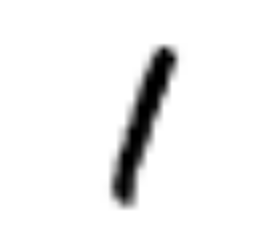

In [23]:
# Plot a random image
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

_unchecked_

## 池层

通常情况下, 人们需要控制参数的数量, 特别是当有深的网络。对于卷积层的每一层输出 (每个层, 对应于一个过滤器的输出), 一个可以有一个汇聚层。池层通常被引入到:-减少上一层的维度 (加速网络)-使模型更能容忍图像中对象位置的变化。例如, 即使数字被移到图像的一侧而不是中间, classifer 也会很好地执行分类任务。

在池节点上的计算比正常的前馈节点要简单得多。 它没有重量, 偏见, 或激活功能。 它使用一个简单的聚合函数 (如 max 或平均值) 来计算其输出。 最常用的函数是 "max"-最大池节点只输出与输入的筛选位置对应的最大输入值。下图显示了 4 x 4 区域的输入值。最大池窗口大小为 2 x 2, 从左上角开始。窗口中的最大值将成为该区域的输出。每次模型按步幅参数指定的量 (如下图所示) 移位, 并重复最大池操作。![maxppool](https://cntk.ai/jup/201/MaxPooling.png)

_unchecked_

另一个选择是平均池, 它会发出平均值而不是最大值。下面的动画总结了两种不同的池 opearations。

In [24]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/c103d_max_pooling.gif" , 'Max pooling'),
          ("https://www.cntk.ai/jup/c103d_average_pooling.gif", 'Average pooling')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=300, height=300))

Max pooling


Average pooling


_unchecked_

## 典型卷积网络

![](http://www.cntk.ai/jup/conv103d_mnist-conv-mp.png)

一个典型的 CNN 包含一组交替的卷积和汇聚层, 接着是稠密的输出层进行分类。您将在许多经典的深网络 (VGG、AlexNet 等) 中找到这种结构的变体。 这与我们在 CNTK_103C 中使用的 MLP 网络形成对比, 它由2稠密的层组成, 接着是稠密的输出层。

插图是在2维 (2D) 图像的上下文中提出的, 但概念和 CNTK 组件可以在任何维度数据上操作。上面的示意图显示了2卷积层和2最大池层。一个典型的策略是增加更深层中的过滤器数量, 同时减少每个中间层的空间大小。中间层。

_unchecked_

## 任务: 使用 MaxPooling 创建网络

典型的卷积网络具有交错卷积和最大池层。以前的模型只有卷积层。在本节中, 您将创建具有以下体系结构的模型。

![](https://www.cntk.ai/jup/cntk103d_conv_max2.png)

您将使用 CNTK [MaxPooling](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.MaxPooling)函数来完成此任务。您将编辑下面的 `create_model` 函数并添加 MaxPooling 操作。

提示: 我们提供了下面几个细胞的解决方案。不要向前看, 先尝试添加图层。

In [25]:
# Modify this model
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            r = C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r
        
# do_train_test()

_unchecked_

**测验**: 在模型中有多少参数具有 MaxPooling 和卷积？两个模型中哪一个会产生较低的错误率？

**勘探建议**-使用 LeakyRelu 有助于提高错误率吗？
-最后一个稠密层所占的参数的百分比是 w.r.t. (a) 纯两个卷积层和 (b) 交替2卷积和 maxpooling 层的参数总数

_unchecked_

## 解决

In [26]:
# function to build model
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(1,1), 
                                       pad=True, name="first_conv")(h)
            h = C.layers.MaxPooling(filter_shape=(2,2), 
                                    strides=(2,2), name="first_max")(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(1,1), 
                                       pad=True, name="second_conv")(h)
            h = C.layers.MaxPooling(filter_shape=(3,3), 
                                    strides=(3,3), name="second_max")(h)
            r = C.layers.Dense(num_output_classes, activation = None, name="classify")(h)
            return r
        
do_train_test()

Minibatch: 0, Loss: 2.3257, Error: 96.88%
Minibatch: 500, Loss: 0.0592, Error: 0.00%
Minibatch: 1000, Loss: 0.1007, Error: 3.12%
Minibatch: 1500, Loss: 0.1299, Error: 3.12%
Minibatch: 2000, Loss: 0.0077, Error: 0.00%
Minibatch: 2500, Loss: 0.0337, Error: 1.56%
Minibatch: 3000, Loss: 0.0038, Error: 0.00%
Minibatch: 3500, Loss: 0.0856, Error: 3.12%
Minibatch: 4000, Loss: 0.0052, Error: 0.00%
Minibatch: 4500, Loss: 0.0171, Error: 1.56%
Minibatch: 5000, Loss: 0.0266, Error: 1.56%
Minibatch: 5500, Loss: 0.0028, Error: 0.00%
Minibatch: 6000, Loss: 0.0070, Error: 0.00%
Minibatch: 6500, Loss: 0.0144, Error: 0.00%
Minibatch: 7000, Loss: 0.0083, Error: 0.00%
Minibatch: 7500, Loss: 0.0033, Error: 0.00%
Minibatch: 8000, Loss: 0.0114, Error: 0.00%
Minibatch: 8500, Loss: 0.0589, Error: 1.56%
Minibatch: 9000, Loss: 0.0186, Error: 1.56%
Training took 31.9 sec
Average test error: 1.05%
